<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1I2wUTT12p5bX3RCku_T_82aD4tkY9LVY" width=600 height=480/></p>
<h3 style="text-align: center;"><b>Школа глубокого обучения ФПМИ МФТИ</b></h3>

<h3 style="text-align: center;"><b>Домашнее задание. Сегментация изображений</b></h3>


В этом задании вам предстоит решить задачу сегментации медицинских снимков. Часть кода с загрузкой данных написана за вас. Всю содержательную сторону вопроса вам нужно заполнить самостоятельно. Задание оценивается из 15 баллов.

Обратите внимание, что отчёт по заданию стоит целых 6 баллов. Он вынесен в отдельный пункт в конце тетради. Это сделано для того, чтобы тетрадь была оформлена как законченный документ о проведении экспериментов. Неотъемлемой составляющей отчёта является ответ на следующие вопросы:

* Что было сделано? Что получилось реализовать, что не получилось?
* Какие результаты ожидалось получить?
* Какие результаты были достигнуты?
* Чем результаты различных подходов отличались друг от друга и от бейзлайна (если таковой присутствует)?




---


1. Для начала мы скачаем датасет: [ADDI project](https://www.fc.up.pt/addi/ph2%20database.html).

<table><tr><td>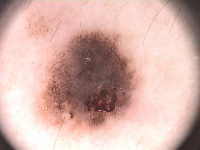</td><td>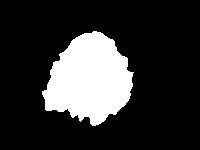</td></tr></table>

2. Разархивируем .rar файл.
3. Обратите внимание, что папка  `PH2 Dataset images` должна лежать там же где и ipynb notebook.

Это фотографии двух типов **поражений кожи:** меланома и родинки.
В данном задании мы не будем заниматься их классификацией, а будем **сегментировать** их.

# Загрузка данных

In [1]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: Error: credential propagation was unsuccessful

In [ ]:
cd /content/drive/MyDrive/Work/Jobs/DLS_mentor/Semester_1/hws_solved/hw16

In [ ]:
!wget -c https://www.dropbox.com/s/8lqrloi0mxj2acu/PH2Dataset.rar

# если по ссылке слишком много запросов, датасет можно скачать с kaggle: https://www.kaggle.com/datasets/kanametov/ph2dataset

In [ ]:
get_ipython().system_raw("unrar x PH2Dataset.rar")

Стуктура датасета у нас следующая:

    IMD_002/
        IMD002_Dermoscopic_Image/
            IMD002.bmp
        IMD002_lesion/
            IMD002_lesion.bmp
        IMD002_roi/
            ...
    IMD_003/
        ...
        ...

 Здесь `X.bmp` — изображение, которое нужно сегментировать, `X_lesion.bmp` — результат сегментации.

Для загрузки датасета можно использовать skimage: [`skimage.io.imread()`](https://scikit-image.org/docs/dev/api/skimage.io.html)

In [ ]:
images = []
lesions = []
from skimage.io import imread
import os
root = 'PH2Dataset'

for root, dirs, files in os.walk(os.path.join(root, 'PH2 Dataset images')):
    if root.endswith('_Dermoscopic_Image'):
        images.append(imread(os.path.join(root, files[0])))
    if root.endswith('_lesion'):
        lesions.append(imread(os.path.join(root, files[0])))

Изображения имеют разные размеры. Давайте изменим их размер на $256\times256 $ пикселей. Для изменения размера изображений можно использовать [`skimage.transform.resize()`](https://scikit-image.org/docs/dev/api/skimage.transform.html#skimage.transform.resize).
Эта функция также автоматически нормализует изображения в диапазоне $[0,1]$.


In [ ]:
from skimage.transform import resize
size = (256, 256)
X = [resize(x, size, mode='constant', anti_aliasing=True,) for x in images]
Y = [resize(y, size, mode='constant', anti_aliasing=False) > 0.5 for y in lesions]

In [ ]:
import numpy as np
X = np.array(X, np.float32)
Y = np.array(Y, np.float32)
print(f'Loaded {len(X)} images')

Чтобы убедиться, что все корректно, мы нарисуем несколько изображений

In [ ]:
import matplotlib.pyplot as plt
from IPython.display import clear_output

plt.figure(figsize=(18, 6))
for i in range(6):
    plt.subplot(2, 6, i+1)
    plt.axis("off")
    plt.imshow(X[i])

    plt.subplot(2, 6, i+7)
    plt.axis("off")
    plt.imshow(Y[i])
plt.show();

Разделим наши 200 картинок на 100/50/50
 для обучения, валидации и теста соответственно

In [ ]:
ix = np.random.choice(len(X), len(X), False)
tr, val, ts = np.split(ix, [100, 150])

In [ ]:
print(len(tr), len(val), len(ts))

## PyTorch DataLoader

In [2]:
from torch.utils.data import DataLoader
batch_size = 25 # default = 25
train_dataloader = DataLoader(list(zip(np.rollaxis(X[tr], 3, 1), Y[tr, np.newaxis])),
                     batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(list(zip(np.rollaxis(X[val], 3, 1), Y[val, np.newaxis])),
                      batch_size=batch_size, shuffle=True)
test_dataloader = DataLoader(list(zip(np.rollaxis(X[ts], 3, 1), Y[ts, np.newaxis])),
                     batch_size=batch_size, shuffle=True)

KeyboardInterrupt: 

In [ ]:
import torch
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

# Метрика

## IoU (intersection over union)

В данном разделе предлагается использовать следующую метрику для оценки качества:

$I o U=\frac{\text {target } \cap \text { prediction }}{\text {target } \cup{prediction }}$

Пересечение (A ∩ B) состоит из пикселей, найденных как в маске предсказания, так и в основной маске истины, тогда как объединение (A ∪ B) просто состоит из всех пикселей, найденных либо в маске предсказания, либо в целевой маске.


Для примера посмотрим на истину (слева) и предсказание (справа):
![alt text](https://www.jeremyjordan.me/content/images/2018/05/target_prediction.png)


Тогда пересечение и объединение будет выглядеть так:

![alt text](https://www.jeremyjordan.me/content/images/2018/05/intersection_union.png)

Что будет являться пересением и объединением в задаче сегментации?

Давайте разберем следующий пример:





<p style="align: center;"><img align=center src="https://drive.google.com/uc?export=view&id=1rBYFgli48AUUN9idiyq8j3J5DboB93yN" width=1000 height=800/></p>

Мы можем сформулировать IoU в терминах матрицы ошибок

Чтобы проверять свои функции на корректность, давайте воспользуемся библиотекой [torchmetrics](https://lightning.ai/docs/torchmetrics/stable/classification/jaccard_index.html)

In [ ]:
!pip install torchmetrics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 841.5/841.5 kB 4.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-many

In [ ]:
### ЭТА ФУНКЦИЯ НЕВЕРНАЯ

# def iou_pytorch(outputs: torch.Tensor, labels: torch.Tensor):
#     # You can comment out this line if you are passing tensors of equal shape
#     # But if you are passing output from UNet or something it will most probably
#     # be with the BATCH x 1 x H x W shape
#     outputs = outputs.squeeze(1).byte()  # BATCH x 1 x H x W => BATCH x H x W
#     labels = labels.squeeze(1).byte()
#     SMOOTH = 1e-8
#     intersection = (outputs & labels).float().sum((1, 2))  # Will be zero if Truth=0 or Prediction=0
#     union = (outputs | labels).float().sum((1, 2))         # Will be zzero if both are 0

#     iou = (intersection + SMOOTH) / (union + SMOOTH)  # We smooth our devision to avoid 0/0

#     thresholded = torch.clamp(20 * (iou - 0.5), 0, 10).ceil() / 10  # This is equal to comparing with thresolds

#     return thresholded

In [ ]:
from torchmetrics import JaccardIndex

jaccard = JaccardIndex(threshold=0.5, task="binary", average='none').to(device)

In [ ]:
def iou_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    # Lets compute metrics for some threshold
    # first convert mask values to probabilities, then
    # apply thresholding

    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    iou = (tp + eps) / (tp + fp + fn + eps)

    return iou

In [ ]:
path_to_dummy_samples = '/content/drive/MyDrive/Work/Jobs/DLS_mentor/Semester_1/hws_solved/hw16/for_asserts'
dummpy_sample = {'logits': torch.load(f'{path_to_dummy_samples}/logits.pt'),
                 'labels': torch.load(f'{path_to_dummy_samples}/labels.pt')}
dummpy_sample['labels'] = dummpy_sample['labels'].to(device)
dummpy_sample['logits'] = dummpy_sample['logits'].to(device)

In [ ]:
print(dummpy_sample['logits'])
print(dummpy_sample['logits'].sigmoid())
print(dummpy_sample['labels'])

tensor([[[[-1.9818, -3.0264, -3.4634, -3.3669],
          [-3.3132, -3.2690,  0.0526, -3.0650],
          [-3.1722,  0.2558,  0.2902, -3.2031],
          [-3.0457, -3.0761, -3.1206, -3.1873]]]])
tensor([[[[0.1211, 0.0462, 0.0304, 0.0333],
          [0.0351, 0.0367, 0.5131, 0.0446],
          [0.0402, 0.5636, 0.5720, 0.0390],
          [0.0454, 0.0441, 0.0423, 0.0396]]]])
tensor([[[[0., 0., 0., 0.],
          [0., 1., 1., 0.],
          [0., 1., 0., 0.],
          [0., 0., 0., 0.]]]])


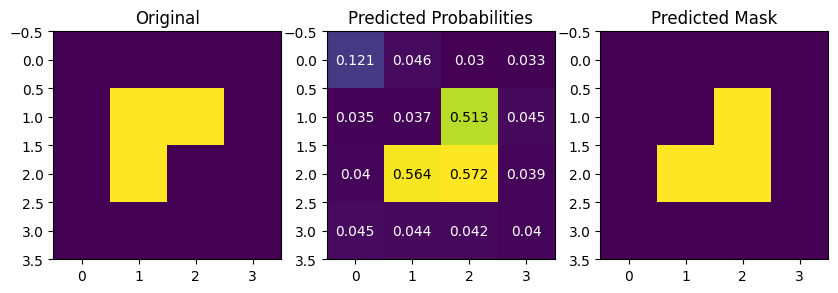

In [ ]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize= (10,3*10))

ax1.imshow(dummpy_sample['labels'].squeeze(1)[0].cpu())
ax1.set_title("Original")

ax2.imshow(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu())
for (j,i),label in np.ndenumerate(dummpy_sample['logits'].sigmoid().squeeze(1)[0].cpu()):
    if label < 0.5:
        color = 'white'
    else:
        color = 'black'
    ax2.text(i,j,round(label,3), color=color, ha='center',va='center')

ax2.set_title("Predicted Probabilities")

ax3.imshow((dummpy_sample['logits'].sigmoid() > 0.5).squeeze(1)[0].cpu())
ax3.set_title("Predicted Mask")
plt.show()

In [ ]:
iou_ours = iou_score(dummpy_sample['logits'], dummpy_sample['labels'], threshold = 0.5)
iou_torch = jaccard(dummpy_sample['logits'], dummpy_sample['labels'])

In [ ]:
assert iou_torch == iou_ours

# Loss

## BCE Loss

### Функция потерь [1 балл]

Не менее важным, чем построение архитектуры, является определение **оптимизатора** и **функции потерь.**

Функция потерь - это то, что мы пытаемся минимизировать. Многие из них могут быть использованы для задачи бинарной семантической сегментации.

Популярным методом для бинарной сегментации является *бинарная кросс-энтропия*, которая задается следующим образом:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

где $y$ это  таргет желаемого результата и $\hat y$ является выходом модели. $\sigma$ - это [*логистическая* функция](https://en.wikipedia.org/wiki/Sigmoid_function), который преобразует действительное число $\mathbb R$ в вероятность $[0,1]$.

Однако эта потеря страдает от проблем численной нестабильности. Самое главное, что $\lim_{x\rightarrow0}\log(x)=\infty$ приводит к неустойчивости в процессе оптимизации. Рекомендуется посмотреть следующее [упрощение](https://www.tensorflow.org/api_docs/python/tf/nn/sigmoid_cross_entropy_with_logits). Эта функция эквивалентна первой и не так подвержена численной неустойчивости:

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Итак, давайте разбираться с этим лоссом.

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Давайте поработаем с выражением внутри суммы:

$$ y_i \cdot -\log\sigma(\hat y_i) + (1-y_i)\cdot -\log(1-\sigma(\hat y_i)) $$

Для удобства давайте обозначим за $z = y_i, x = \hat y_i$, т.е.

$$ z \cdot -\log\sigma(x) + (1-z)\cdot -\log(1-\sigma(x)) $$

$$ \sigma(x) = \frac{1}{1 + e^{-x}} $$

$$ 1- \sigma(x) = 1 - \frac{1}{1 + e^{-x}} = \frac{1 + e^{-x} - 1}{1 + e^{-x}} = \frac{e^{-x}}{1 + e^{-x}} $$

$$ z \cdot -\log\sigma(x) + (1-z)\cdot -\log(1-\sigma(x)) = z \cdot -\log(\frac{1}{1 + e^{-x}}) + (1-z) \cdot -\log(\frac{e^{-x}}{1 + e^{-x}}) = $$

$$z \cdot -(\log1 - \log(1 + e^{-x}) + (1-z) \cdot -(\log(e^{-x}) - log(1 + e^{-x})) = $$

$$z \cdot \log(1 + e^{-x}) + (1-z) (x + \log(1 + e^{-x})) = (1-z)x + log(1 + e^{-x}) = x - zx + log(1 + e^{-x})$$

$$z \cdot -\log\sigma(x) + (1-z)\cdot -\log(1-\sigma(x)) = x - zx + log(1 + e^{-x})$$

Вернемся к нашей замене:

$$y_i \cdot -\log\sigma(\hat y_i) + (1-y_i)\cdot -\log(1-\sigma(\hat y_i)) = \hat y_i - y_i \hat y_i + \log(1+e^{-{\hat y_i}})$$

Не забываем, что здесь $\hat y_i$ - это логиты сети, не вероятности и не лейблы.

$$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$

Напишем 4 функции:



*   `bce_true()` - честная прямая реализация лосса с формулой $$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$
*   `bce_loss()` - реализация формулы, которую мы вывели $$\mathcal L_{BCE} = \hat y - y\hat y + \log\left(1+\exp(-\hat y)\right).$$
*   `bce_torch()`
*   `bce_torch_with_logits()`



In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
def bce_loss(y_pred, y_real):
    # TODO

    # please don't use nn.BCELoss. write it from scratch
    # y_real - labels, y_pred - logits
    return (y_pred - y_real * y_pred + torch.log(1 + torch.exp(-y_pred))).sum()

def bce_true(y_pred, y_real):
  # y_real - labels, y_pred - logits
  return -(y_real * torch.log(torch.sigmoid(y_pred)) + (1 - y_real) * torch.log(1 - torch.sigmoid(y_pred))).sum()

bce_torch = nn.BCELoss(reduction='sum') # (sigmoid(y_pred), y_real)
bce_torch_with_logits = nn.BCEWithLogitsLoss(reduction='sum')

Проверим корректность работы на dummy примере

In [ ]:
input = torch.randn(3, 2, requires_grad=False)
target = torch.rand(3, 2, requires_grad=False)

print(f'BCE loss from scratch bce_loss = {bce_loss(input, target)}')
print(f'BCE loss честно посчитанный = {bce_true(input, target)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(input), target)}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(input, target)}')


BCE loss from scratch bce_loss = 3.9021615982055664
BCE loss честно посчитанный = 3.9021618366241455
BCE loss from torch bce_torch = 3.9021615982055664
BCE loss from torch with logits bce_torch = 3.9021615982055664


In [ ]:
assert bce_loss(input, target) == bce_torch(torch.sigmoid(input), target)

Давайте теперь посчитаем на dummy примере, но с теми же размерностями, что и в датасете

In [ ]:
y_pred = torch.randn((2, 1, 3, 3), requires_grad=False)
y_true = torch.randint(0, 2, (2, 1, 3, 3))

print(f'BCE loss from scratch bce_loss = {bce_loss(y_pred, y_true)}')
print(f'BCE loss честно посчитанный = {bce_true(y_pred, y_true)}')
print(f'BCE loss from torch bce_torch = {bce_torch(torch.sigmoid(y_pred), y_true.to(torch.float))}')
print(f'BCE loss from torch with logits bce_torch = {bce_torch_with_logits(y_pred, y_true.to(torch.float))}')

BCE loss from scratch bce_loss = 14.42103099822998
BCE loss честно посчитанный = 14.421030044555664
BCE loss from torch bce_torch = 14.421030044555664
BCE loss from torch with logits bce_torch = 14.421030044555664


In [ ]:
assert bce_loss(dummpy_sample['logits'], dummpy_sample['labels']) == bce_torch(torch.sigmoid(dummpy_sample['logits']), dummpy_sample['labels'].float())

## Дополнительные функции потерь [2 балла]

### Dice Loss

 В данном разделе вам потребуется имплементировать две функции потерь:
 DICE и Focal loss.
 Если у вас что-то не учится, велика вероятность, что вы ошиблись или учите слишком мало эпох, прежде чем бить тревогу попробуйте перебрать различные варианты и убедитесь, что во всех других сетапах сеть достигает желанного результата. СПОЙЛЕР: учиться она будет при всех лоссах, предложенных в этом задании.


**1. Dice coefficient:** Учитывая две маски $X$ и $Y$, общая метрика для измерения расстояния между этими двумя масками задается следующим образом:

$$D(X,Y)=\frac{2|X\cap Y|}{|X|+|Y|}$$

Эта функция не является дифференцируемой, но это необходимое свойство для градиентного спуска. В данном случае мы можем приблизить его с помощью:

$$\mathcal L_D(X,Y) = 1-  \frac{\sum_i2X_iY_i}{\sum_iX_i+Y_i}.$$

Не забудьте подумать о численной нестабильности, возникающей в математической формуле.


In [ ]:
def dice_score(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):
    '''
    Это именно метрика, не лосс.
    '''

    prob_mask = logits.sigmoid()
    pred_mask = (prob_mask > threshold).float()
    labels = labels.float()

    tp = torch.sum(pred_mask*labels)
    fp = torch.sum(pred_mask) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    score = (2. * tp + eps) / (2. * tp + fp + fn + eps)

    return score

def dice_loss(logits: torch.Tensor, labels: torch.Tensor, threshold: float = 0.5):

    prob = torch.sigmoid(logits)
    pred_mask = (prob > threshold)
    prob_masked = prob * pred_mask

    tp = torch.sum(prob_masked*labels)
    fp = torch.sum(prob_masked) - tp
    fn = torch.sum(labels) - tp

    eps = 1e-8 # to avoid 0/0
    score = (2. * tp + eps) / (2. * tp + fp + fn + eps)
    loss = 1 - score
    return loss

In [ ]:
from torchmetrics.classification import Dice

dice = Dice(average='micro').to(device)
dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int))

tensor(0.6667)

In [ ]:
dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

tensor(0.6667)

In [ ]:
assert dice(dummpy_sample['logits'].sigmoid(), dummpy_sample['labels'].to(int)) == dice_score(dummpy_sample['logits'], dummpy_sample['labels'])

### Focal Loss

[**2. Focal loss:**](https://arxiv.org/pdf/1708.02002.pdf)

Окей, мы уже с вами умеем делать BCE loss:

$$\mathcal L_{BCE}(y, \hat y) = -\sum_i \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Проблема с этой потерей заключается в том, что она имеет тенденцию приносить пользу классу **большинства** (фоновому) по отношению к классу **меньшинства** ( переднему). Поэтому обычно применяются весовые коэффициенты к каждому классу:

$$\mathcal L_{wBCE}(y, \hat y) = -\sum_i \alpha_i\left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Традиционно вес $\alpha_i$ определяется как обратная частота класса этого пикселя $i$, так что наблюдения миноритарного класса весят больше по отношению к классу большинства.

Еще одним недавним дополнением является взвешенный пиксельный вариант, которая взвешивает каждый пиксель по степени уверенности, которую мы имеем в предсказании этого пикселя.

$$\mathcal L_{focal}(y, \hat y) = -\sum_i \left[\left(1-\sigma(\hat y_i)\right)^\gamma y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

Зафиксируем значение $\gamma=2$.

--------------------------------------------------------------------------------


Выше формула неверная.

Вот верная, взятая из оригинальной статьи по [Focal Loss](https://arxiv.org/pdf/1708.02002.pdf):

$$p_t = \sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)$$

$$\mathcal L_{focal}(y, \hat y) = (1 - p_t)^{\gamma} \mathcal L_{BCE}(y_i, \hat y_i).$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - p_t)^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

$$\mathcal L_{focal}(y, \hat y) = -\sum_i (1 - (\sigma(\hat y_i)y_i + (1 - \sigma(\hat y_i)) (1-y_i)))^{\gamma} \left[y_i\log\sigma(\hat y_i) + (1-y_i)\log(1-\sigma(\hat y_i))\right].$$

In [ ]:
from torchvision.ops import sigmoid_focal_loss

In [ ]:
def focal_loss(y_real, y_pred, eps = 1e-8, gamma = 2):
    targets = y_real
    inputs = y_pred

    p = torch.sigmoid(inputs)
    ce_loss = F.binary_cross_entropy_with_logits(inputs, targets, reduction="none")
    p_t = p * targets + (1 - p) * (1 - targets)
    loss = ce_loss * ((1 - p_t) ** gamma)

    return loss.sum()

In [ ]:
focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

tensor(3.6161)

In [ ]:
sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum')

tensor(3.6161)

In [ ]:
assert sigmoid_focal_loss(dummpy_sample['logits'], dummpy_sample['labels'], alpha=-1, gamma=2, reduction='sum') == focal_loss(dummpy_sample['labels'], dummpy_sample['logits'], gamma=2.0)

# Реализация различных архитектур:
Ваше задание будет состоять в том, чтобы написать несколько нейросетевых архитектур для решения задачи семантической сегментации. Сравнить их по качеству на тесте и испробовать различные лосс функции для них.

-----------------------------------------------------------------------------------------

# SegNet [2 балла]

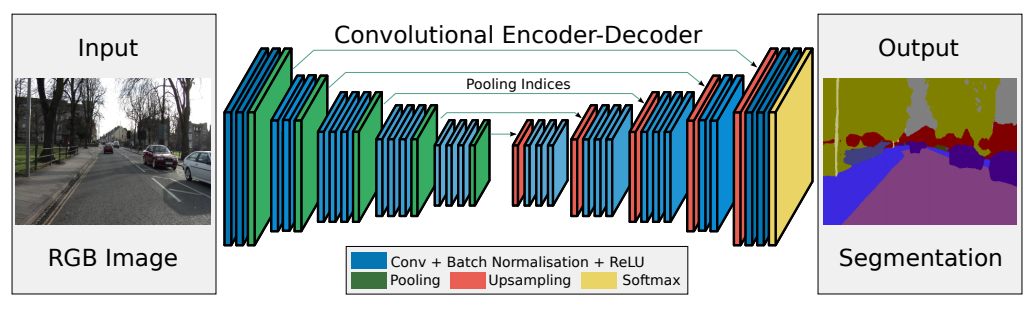

* Badrinarayanan, V., Kendall, A., & Cipolla, R. (2015). [SegNet: A deep convolutional
encoder-decoder architecture for image segmentation](https://arxiv.org/pdf/1511.00561.pdf)

Внимательно посмотрите из чего состоит модель и для чего выбраны те или иные блоки.

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torchvision import models
import torch.optim as optim
from time import time

from matplotlib import rcParams
rcParams['figure.figsize'] = (15,4)

Хорошие ресурсы по SegNet архитектуре:
1. https://medium.com/@nikdenof/segnet-from-scratch-using-pytorch-3fe9b4527239


In [ ]:
import torchvision.models as models

model_ft = models.vgg16(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
model_ft

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace=True)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace=True)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace=True)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace=True)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace=True)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1

In [ ]:
class EncoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, depth):
        super(EncoderBlock, self).__init__()

        self.conv_block = nn.ModuleList()
        for i in range(depth):
            if i == 0:
              self.conv_block.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1))
            else:
              self.conv_block.append(nn.Conv2d(out_ch, out_ch, kernel_size=3, stride=1, padding=1))
            self.conv_block.append(nn.BatchNorm2d(out_ch))
            self.conv_block.append(nn.ReLU(inplace=True))

        self.pool = nn.MaxPool2d(kernel_size=2, stride=2, return_indices=True)

    def forward(self, x):
        for layer in self.conv_block:
            x = layer(x)
        x, indices = self.pool(x)
        return x, indices

class DecoderBlock(nn.Module):
    def __init__(self, in_ch, out_ch, depth, classification=False):
        super(DecoderBlock, self).__init__()

        self.unpool = nn.MaxUnpool2d(kernel_size=2, stride=2)

        self.conv_block = nn.ModuleList()
        for i in range(depth):

            if i == depth - 1:
                self.conv_block.append(nn.Conv2d(in_ch, out_ch, kernel_size=3, stride=1, padding=1))
                if not classification:
                  self.conv_block.append(nn.BatchNorm2d(out_ch))
                  self.conv_block.append(nn.ReLU(inplace=True))
            else:
                self.conv_block.append(nn.Conv2d(in_ch, in_ch, kernel_size=3, stride=1, padding=1))
                self.conv_block.append(nn.BatchNorm2d(in_ch))
                self.conv_block.append(nn.ReLU(inplace=True))

    def forward(self, x, ind):
        x = self.unpool(x, ind)
        for layer in self.conv_block:
            x = layer(x)
        return x

class SegNet(nn.Module):
    def __init__(self, in_channels=3, out_channels=1):
        super().__init__()

        # VGG-16 architecture
        self.enc0 = EncoderBlock(in_channels, 64, depth=2) # [3, 256, 256] --> [64, 128, 128]
        self.enc1 = EncoderBlock(64, 128, depth=2) # [64, 128, 128] --> [128, 64, 64]
        self.enc2 = EncoderBlock(128, 256, depth=3) # [128, 64, 64] --> [256, 32, 32]
        self.enc3 = EncoderBlock(256, 512, depth=3) # [256, 32, 32] --> [512, 16, 16]

        # bottleneck
        self.bottleneck_enc = EncoderBlock(512, 512, depth=3) # [512, 16, 16] --> [512, 8, 8]
        self.bottleneck_dec = DecoderBlock(512, 512, depth=3) # [512, 8, 8] --> [512, 16, 16]

        # decoder (upsampling)
        self.dec0 = DecoderBlock(512, 256, depth=3) # [512, 16, 16] --> [256, 32, 32]
        self.dec1 = DecoderBlock(256, 128, depth=3) # [256, 32, 32] --> [128, 64, 64]
        self.dec2 = DecoderBlock(128, 64, depth = 2) # [128, 64, 64] --> [64, 128, 128]
        self.dec3 = DecoderBlock(64, out_channels, depth=2, classification=True) # No activation # [1, 256, 256]

    def forward(self, x):
        # encoder
        e0, ind0 = self.enc0(x)
        e1, ind1 = self.enc1(e0)
        e2, ind2 = self.enc2(e1)
        e3, ind3 = self.enc3(e2)

        # bottleneck
        b0, indb = self.bottleneck_enc(e3)
        b1 = self.bottleneck_dec(b0, indb)

        # decoder
        d0 = self.dec0(b1, ind3)
        d1 = self.dec1(d0, ind2)
        d2 = self.dec2(d1, ind1)
        d3 = self.dec3(d2, ind0) # no activation

        return d3

## Тренировка [1 балл]

Мы определим цикл обучения в функции, чтобы мы могли повторно использовать его.

In [ ]:
from tqdm.notebook import tqdm

In [ ]:
def train_single_epoch(model, optimizer, criterion, train_dataloader):
    model.train()

    avg_loss = 0
    for X_batch, Y_batch in tqdm(train_dataloader):
        X_batch = X_batch.to(device)
        Y_batch = Y_batch.to(device)
        optimizer.zero_grad()

        Y_pred = model(X_batch)
        loss = criterion(Y_pred, Y_batch) # forward-pass

        # set parameter gradients to zero
        loss.backward()  # backward-pass
        optimizer.step()  # update weights

        # calculate loss to show the user
        avg_loss += loss

    avg_loss = avg_loss/len(train_dataloader)

    return model, avg_loss

def validate_single_epoch(model, criterion, valid_dataloader, plot=False):
    model.eval()

    avg_loss = 0
    avg_iou = 0
    with torch.no_grad():
      for X_batch, Y_batch in tqdm(valid_dataloader):
          X_batch = X_batch.to(device)
          Y_batch = Y_batch.to(device)

          Y_pred = model(X_batch)
          iou = iou_score(X_batch, Y_batch, threshold = 0.5)
          loss = criterion(Y_pred, Y_batch)
          avg_loss += loss
          avg_iou += iou

    avg_loss = avg_loss/len(valid_dataloader)
    avg_iou = avg_iou/len(valid_dataloader)

    if plot:
      # Visualize tools
        clear_output(wait=True)
        for k in range(min(6, X_batch.shape[0])):
            plt.subplot(2, 6, k+1)
            plt.imshow(np.rollaxis(X_batch.cpu()[k].numpy(), 0, 3), cmap='gray')
            plt.title('Real')
            plt.axis('off')

            plt.subplot(2, 6, k+7)
            plt.imshow(Y_pred.detach().cpu()[k, 0], cmap='gray')
            plt.title('Output')
            plt.axis('off')
        plt.suptitle(f'Val loss = {avg_loss}')
        plt.show()

    return model, avg_loss, avg_iou

def train(model, optimizer, criterion, epochs, train_dataloader, valid_dataloader, plot_loss = False):

    total_train_loss = []
    total_val_loss = []
    total_val_iou = []

    for epoch in tqdm(range(epochs)):

        model, train_loss = train_single_epoch(model, optimizer, criterion, train_dataloader)
        model, val_loss, val_iou = validate_single_epoch(model, criterion, valid_dataloader, plot=True)
        print(f'Epoch {epoch}: train loss = {train_loss}')
        print(f'Epoch {epoch}: val loss = {val_loss}')
        print(f'Epoch {epoch}: val iou = {val_iou}')

        total_train_loss.append(train_loss.cpu().detach().numpy())
        total_val_loss.append(val_loss.cpu().detach().numpy())
        total_val_iou.append(val_iou.cpu().detach().numpy())

        if plot_loss:
            fig, (ax1, ax2) = plt.subplots(1, 2)

            ax1.plot(list(range(len(total_train_loss))), total_train_loss, label = 'train loss')
            ax1.plot(list(range(len(total_val_loss))), total_val_loss, label = 'val loss')
            ax2.plot(list(range(len(total_val_iou))), total_val_iou, label = 'val iou')
            ax1.set_title("Loss")
            ax2.set_title("IoU")
            ax1.legend()
            plt.show()

    statistics = {'train loss': total_train_loss,
                  'val_loss': total_val_loss,
                  'val_iou': total_val_iou}

    return model, statistics

## Инференс [1 балл]

После обучения модели эту функцию можно использовать для прогнозирования сегментации на новых данных:

In [ ]:
### НЕНУЖНЫЕ ФУНКЦИИ
def predict(model, data):
    model.eval()  # testing mode
    with torch.no_grad():
      Y_pred = [model(X_batch.to(device)) for X_batch, _ in data]
    return np.array(Y_pred)

In [ ]:
### НЕНУЖНЫЕ ФУНКЦИИ
def score_model(model, metric, data):
    model = model.to(device)
    model.eval()  # testing mode
    scores = 0
    with torch.no_grad():
      for X_batch, Y_label in data:
          Y_pred = model(X_batch.to(device)) # <TODO>
          scores += metric(Y_pred, Y_label.to(device)).mean().item()

    return scores/len(data)

Давайте проверим модель нашу

In [ ]:
model = SegNet()
PATH_TO_CHECKPOINTS = '/content/drive/MyDrive/Work/Jobs/DLS_mentor/Semester_1/hws_solved/hw16/checkpoints/checkpoint_0.pth'
model.load_state_dict(torch.load(PATH_TO_CHECKPOINTS, map_location=torch.device(device)))
model.eval();
model = model.to(device)

## Основной момент: обучение

Обучите вашу модель. Обратите внимание, что обучать необходимо до сходимости. Если указанного количества эпох (20) не хватило, попробуйте изменять количество эпох до сходимости алгоритма. Сходимость определяйте по изменению функции потерь на валидационной выборке.
 С параметрами оптимизатора можно спокойно играть, пока вы не найдете лучший вариант для себя.


In [ ]:
model = SegNet().to(device)

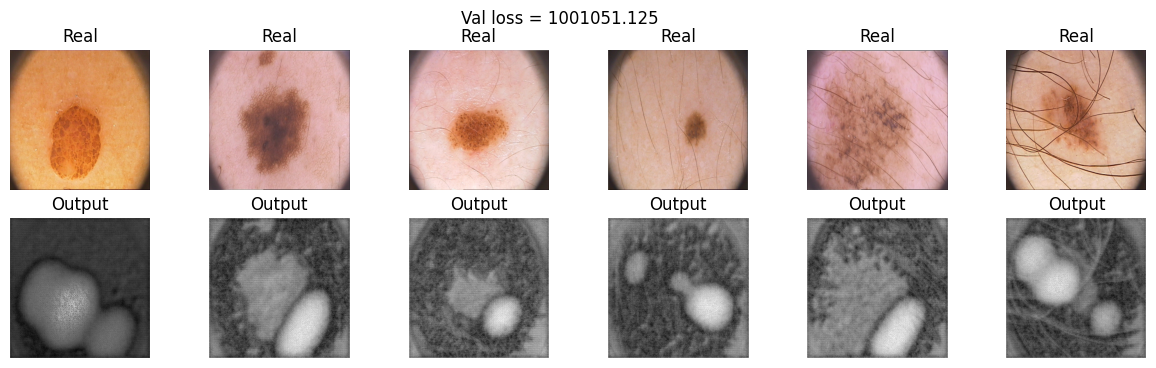

Epoch 1: train loss = 866636.0625
Epoch 1: val loss = 1001051.125
Epoch 1: val iou = 0.42988282442092896


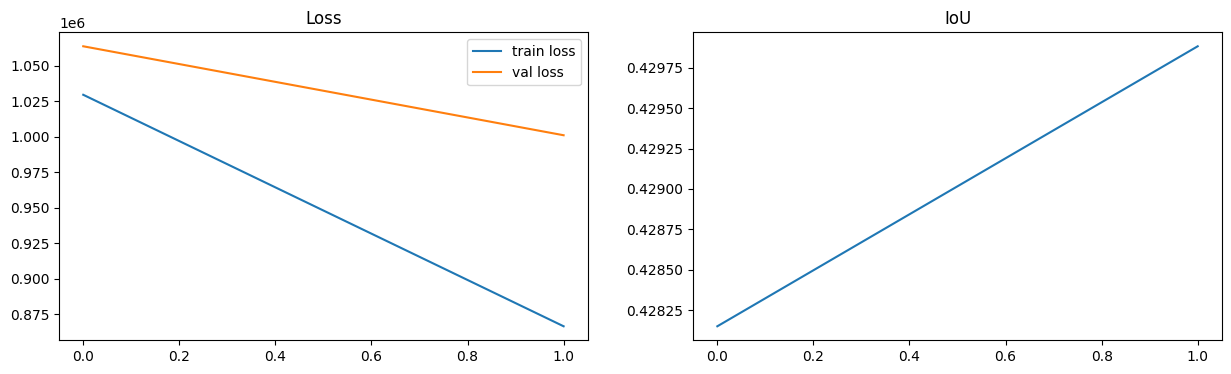

  0%|          | 0/4 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
max_epochs = 20
optim = torch.optim.Adam(model.parameters())
model, statistics_bce_loss = train(model, optim, bce_loss, max_epochs, data_tr, data_val, plot_loss=True)
# save_dir = '/content/drive/MyDrive/Work/Jobs/DLS_mentor/Semester_1/hws_solved/hw16/checkpoints'
# torch.save(model.state_dict(), f"{save_dir}/checkpoint_0.pth")

In [ ]:
max(statistics['val_iou'])

NameError: name 'statistics_bce_loss' is not defined

Ответьте себе на вопрос: не переобучается ли моя модель?

----------------------------------------------------------------------------------------------

## [BONUS] Мир сегментационных лоссов [5 баллов]

В данном блоке предлагаем вам написать одну функцию потерь самостоятельно. Для этого необходимо прочитать статью и имплементировать ее. Кроме тако провести численное сравнение с предыдущими функциями.
Какие варианты?

1) Можно учесть Total Variation
2) Lova
3) BCE но с Soft Targets (что-то типа label-smoothing для многослассовой классификации)
4) Любой другой

* [Physiological Inspired Deep Neural Networks for Emotion Recognition](https://ieeexplore.ieee.org/stamp/stamp.jsp?arnumber=8472816&tag=1)". IEEE Access, 6, 53930-53943.

* [Boundary loss for highly unbalanced segmentation](https://arxiv.org/abs/1812.07032)

* [Tversky loss function for image segmentation using 3D fully convolutional deep networks](https://arxiv.org/abs/1706.05721)

* [Correlation Maximized Structural Similarity Loss for Semantic Segmentation](https://arxiv.org/abs/1910.08711)

* [Topology-Preserving Deep Image Segmentation](https://papers.nips.cc/paper/8803-topology-preserving-deep-image-segmentation)

Так как Тверский лосс очень похож на данные выше, то за него будет проставлено только 3 балла (при условии, если в модели нет ошибок при обучении). Постарайтесь сделать что-то интереснее.

In [ ]:
<TODO>

-----------------------------------------------------------------------------------------

# U-Net [2 балла]

[**U-Net**](https://arxiv.org/abs/1505.04597) — это архитектура нейронной сети, которая получает изображение и выводит его. Первоначально он был задуман для семантической сегментации (как мы ее будем использовать), но он настолько успешен, что с тех пор используется в других контекстах. Получая на вход медицинское изображение, он выведет изображение в оттенках серого, где интенсивность каждого пикселя зависит от вероятности того, что этот пиксель принадлежит интересующей нас области.

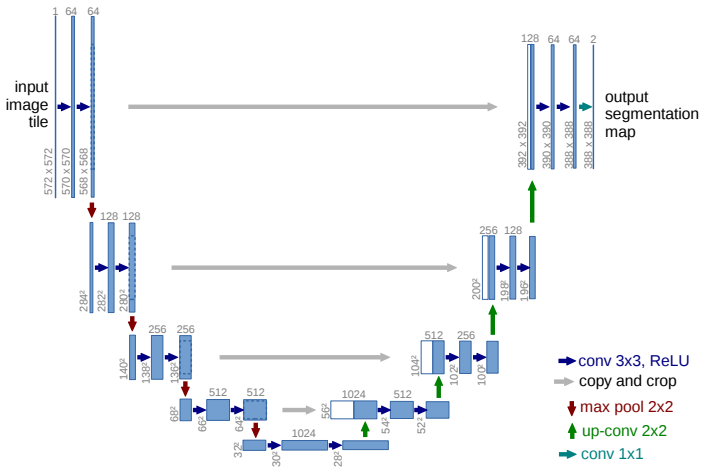

У нас в архитектуре все так же существует энкодер и декодер, как в **SegNet**, но отличительной особеностью данной модели являются *skip-conenctions*, соединяющие части декодера и энкодера. То есть для того чтобы передать на вход декодера тензор, мы конкатенируем симметричный выход с энкодера и выход предыдущего слоя декодера.

* Ronneberger, Olaf, Philipp Fischer, and Thomas Brox. "[U-Net: Convolutional networks for biomedical image segmentation.](https://arxiv.org/pdf/1505.04597.pdf)" International Conference on Medical image computing and computer-assisted intervention. Springer, Cham, 2015.

In [ ]:
import torch.nn.functional as F
import torch.nn as nn

In [ ]:
class UNet(nn.Module):
    def __init__(self, n_class=1):
        super().__init__()

        # Encoder
        # In the encoder, convolutional layers with the Conv2d function are used to extract features from the input image.
        # Each block in the encoder consists of two convolutional layers followed by a max-pooling layer, with the exception of the last block which does not include a max-pooling layer.
        # -------
        # input: 572x572x3
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1) # output: 570x570x64
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1) # output: 568x568x64
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 284x284x64

        # input: 284x284x64
        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1) # output: 282x282x128
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1) # output: 280x280x128
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 140x140x128

        # input: 140x140x128
        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1) # output: 138x138x256
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1) # output: 136x136x256
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 68x68x256

        # input: 68x68x256
        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1) # output: 66x66x512
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1) # output: 64x64x512
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2) # output: 32x32x512

        # input: 32x32x512
        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1) # output: 30x30x1024
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1) # output: 28x28x1024


        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)

        # Output layer
        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)

    def forward(self, x):
        # Encoder
        xe11 = F.relu(self.e11(x))
        xe12 = F.relu(self.e12(xe11))
        xp1 = self.pool1(xe12)

        xe21 = F.relu(self.e21(xp1))
        xe22 = F.relu(self.e22(xe21))
        xp2 = self.pool2(xe22)

        xe31 = F.relu(self.e31(xp2))
        xe32 = F.relu(self.e32(xe31))
        xp3 = self.pool3(xe32)

        xe41 = F.relu(self.e41(xp3))
        xe42 = F.relu(self.e42(xe41))
        xp4 = self.pool4(xe42)

        xe51 = F.relu(self.e51(xp4))
        xe52 = F.relu(self.e52(xe51))

        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = F.relu(self.d11(xu11))
        xd12 = F.relu(self.d12(xd11))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = F.relu(self.d21(xu22))
        xd22 = F.relu(self.d22(xd21))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = F.relu(self.d31(xu33))
        xd32 = F.relu(self.d32(xd31))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = F.relu(self.d41(xu44))
        xd42 = F.relu(self.d42(xd41))

        # Output layer
        out = self.outconv(xd42)

        return out

In [ ]:
unet_model = UNet().to(device)

NameError: name 'device' is not defined

In [ ]:
train(unet_model, optim.Adam(unet_model.parameters()), bce_loss, 20, data_tr, data_val)

In [ ]:
score_model(unet_model, iou_pytorch, data_val)

Новая модель путем изменения типа пулинга:

 **Max-Pooling** for the downsampling and **nearest-neighbor Upsampling** for the upsampling.

Down-sampling:

        conv = nn.Conv2d(3, 64, 3, padding=1)
        pool = nn.MaxPool2d(3, 2, padding=1)

Up-Sampling

        upsample = nn.Upsample(32)
        conv = nn.Conv2d(64, 64, 3, padding=1)

Замените max-pooling на convolutions с stride=2 и upsampling на transpose-convolutions с stride=2.


In [ ]:
class UNet2(nn.Module):


In [ ]:
unet2_model = UNet2().to(device)


In [ ]:
train(unet2_model, optim.Adam(unet2_model.parameters()), bce_loss, 5, data_tr, data_val)

Сделайте вывод, какая из моделей лучше

# Отчет (6 баллов):
Ниже предлагается написать отчет о проделанно работе и построить графики для лоссов, метрик на валидации и тесте.
Если вы пропустили какую-то часть в задании выше, то вы все равно можете получить основную часть баллов в отчете, если правильно зададите проверяемые вами гипотезы.


Аккуратно сравните модели между собой и соберите наилучшую архитектуру. Проверьте каждую модель с различными лоссами. Мы не ограничиваем вас в формате отчета, но проверяющий должен отчетливо понять для чего построен каждый график, какие выводы вы из него сделали и какой общий вывод можно сделать на основании данных моделей. Если вы захотите добавить что-то еще, чтобы увеличить шансы получения максимального балла, то добавляйте отдельное сравнение.

Дополнительные комментарии:

Пусть у вас есть N обученных моделей.
- Является ли отчетом N графиков с 1 линей? Да, но очень низкокачественным, потому что проверяющий не сможет сам сравнить их.

- Является ли отчетом 1 график с N линиями? Да, но скорее всего таким образом вы отразили лишь один эффект. Этого мало, чтобы сделать досточно суждений по поводу вашей работа.

- Я проверял метрики на трейне, и привел в результате таблицу с N числами, что не так? ключейвой момент тут, что вы измеряли на трейне ваши метрики, уверены ли вы, что заивисмости останутся такими же на отложенной выборке?

- Я сделал отчет содержащий график лоссов и метрик, и у меня нет ошибок в основной части, но за отчет не стоит максимум, почему? Естестественно максимум баллов за отчет можно получить не за 2 графика (даже при условии их полной правильности). Проверяющий хочет видеть больше сравнений моделей, чем метрики и лоссы (особенно, если они на трейне).

Советы: попробуйте правильно поставить вопрос на который вы себе отвечаете и продемонстрировать таблицу/график, помогающий проверяющему увидеть ответ на этот вопрос. Пример: Ваня хочет узнать, с каким из 4-х лоссов модель (например, U-Net) имеет наилучшее качество. Что нужно сделать Ване? Обучить 4 одинаковых модели с разными лосс функциями. И измерить итогововое качество. Продемонстрировать результаты своих измерений и итоговый вывод. (warning: конечно же, это не идеально ответит на наш вопрос, так как мы не учитываем в экспериментах возможные различные типы ошибок, но для первого приближения этого вполне достаточно).

Примерное время на подготовку отчета 1 час, он содержит сравнеение метрик, график лоссов, выбор лучших моделей из нескольких кластеров и выбор просто лучшей модели, небольшой вывод по всему дз, возможно сравнение результирующих сегментаций, времени или числа параметров модели, проявляйте креативность.